In [1]:

from typing import Sequence, Tuple, Union, Optional, Callable, Literal, Protocol
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike


import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
from jax import random as jrandom
import equinox as eqx

import optax


from functools import partial

from collections.abc import Generator
from typing_extensions import TypeAlias



from dataclasses import dataclass, asdict, astuple

In [2]:
print(jax.devices())


[CudaDevice(id=0)]


# Utils

In [3]:
class Range(eqx.Module):
    minval: float = 0.0
    maxval: float = 1.0

#class ModelState(eqx.Module):
#    S0: float
#    v0: float

class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())

In [5]:
import matplotlib.pyplot as plt

#def plot_differential_data(init_spots, init_vols, payoffs, states: ModelState):
#    # plt.plot(init_spots, payoffs, 'b.', markersize=1.0, label = 'payoffs')
#    plt.plot(init_spots, states.S0, 'r.', markersize=1.0, label = 'dpayoff/dS0')
#
#    print(init_spots.shape)
#    print(states.S0.shape)
#    # plt.plot(init_spots, states
#    # plt.plot(hset.initial_spot_prices, prices, 'r.', markersize=3, label='price')
#    plt.legend()
#    plt.xlabel('initial spot price')
#    plt.ylabel('payoff')
#    # plt.ylim(-1, 1000)
#    plt.show()

def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("$S_0$")
    ax.set_ylabel("\nu_0")
    ax.set_zlabel(label)
    return fig


In [6]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))


In [7]:
def normalize(x, x_mean, x_std):
    return (x - x_mean) / x_std

# HVP stuff

In [8]:

# HVP for single point and single direction from Bachelier
def hvp(f, x, v):
    return jax.jvp(lambda x_: eqx.filter_grad(f)(x_), (x,), (v,))[1]

# from bachelier
def hvp_batch(f, inputs, directions):
    """
    Compute Hessian-vector products: H(x_i) @ v_j
    Args:
        f: scalar-valued function f: R^n -> R
        inputs: [num_inputs, input_dim]
        directions: [num_directions, input_dim]
    Returns:
        hvps: [num_inputs, num_directions, input_dim]
    """
    def hvp_fn(x, v):
        return hvp(f, x, v)
    batched = eqx.filter_vmap(eqx.filter_vmap(hvp_fn, in_axes=(0, None)), in_axes=(None, 0))
    return jnp.transpose(batched(inputs, directions), (1, 0, 2))




# Payoff

In [9]:
class EuropeanPayoff:

    # TODO: naming: strike_prices should be strike_price unless we would like to support an array of strike prices
    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)

    @staticmethod
    def payoff(spot_path, K, payoff_fn = call):
        spot_maturity = spot_path[..., -1]
        payoff = payoff_fn(spot_maturity, K)
        return payoff


def european_payoff(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    payoff = payoff_fn(spot_maturity, K)
    return payoff

def european_payoff_and_deriv(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    # payoff = payoff_fn(spot_maturity, K)
    payoff, dpayoff = jax.value_and_grad(payoff_fn)(spot_maturity, K)
    return payoff, dpayoff

In [10]:
sharpness = 1e-3
bias = sharpness

def smooth_european_payoff(x, k):
    return jax.nn.celu(x=x-k, alpha=sharpness) + bias


fn = lambda x: jax.nn.celu(x=x, alpha=sharpness) + bias
smooth_max_fn = fn


# Heston

In [11]:
#class ModelState(eqx.Module):
#    S0: float
#    v0: float

## just for testing
#class DDModelState(eqx.Module):
#    S0: ModelState
#    v0: ModelState

    
class Heston(eqx.Module):

    ## the state of the model at any given 
    #class State(eqx.Module):
    #    S0: float
    #    v0: float
        
    ## European call option price is at 34.99 for the following config: 
    #class Parameters(eqx.Module):
    #    K: float = 100.0        # Strike price
    #    r: float = 0.05         # Risk-free rate
    #    T: float = 5.0          # n years until expiry, i.e. T2 - T1
    #    rho: float = -0.3       # Correlation of asset and volatility
    #    kappa: float = 2.00     # Mean-reversion rate
    #    theta: float = 0.09     # Long run average volatility
    #    xi: float = 1.00        # Volatility of volatility

    
    #S0: float = 100.0       # Initial spot price
    #v0: float = 0.09        # Initial volatility

    spot_range:Range = Range(50.0, 150.0)
    vol_range: Range = Range(0.01, 0.1)

    mc_time_steps: int = 1024 # number of time steps for the Monte Carlo simulation
     
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.0          # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility

    #@classmethod
    #def from_parameters(cls, parameters: Parameters, **kwargs):
    #    return cls(*astuple(parameters), **kwargs)
    
    #@property
    #def model_state(self) -> ModelState:
    #    return ModelState(self.S0, self.v0)


    def volatility_path(self, vol_draws, v0: float):
        n_steps = len(vol_draws)
        dt = self.T / n_steps

        def vol_path_iter(prev_vol_path, vol_draw):
            # v_truncated = smooth_max_cubic(prev_vol_path)
            v_truncated = smooth_max_fn(prev_vol_path)
            prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
            randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
            current = prev_path_contribution + randomness
            return current, current # use current both for carry and for y

        carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(v0), vol_draws, length=n_steps)

        # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
        vol_path = jnp.roll(vol_path.at[-1].set(v0), 1)
        return vol_path



    def spot_path(self, spot_draws: Array, vol_path: Array, S0:float) -> Array:
        n_steps = len(spot_draws)
        dt = self.T / n_steps

        def spot_path_iter(prev_spot_path, iter_pair):
            spot_draw = iter_pair[0]
            vol = iter_pair[1]
            # v_truncated = smooth_max_cubic(vol)
            v_truncated = smooth_max_fn(vol)
            path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
            return path_new_spot, path_new_spot

        iter_values = jnp.column_stack((spot_draws, vol_path))
        carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(S0), iter_values, length=n_steps)

        # we now have iteration 1 at position 0. Place initial S0 at the end and rotate into initial slot
        spot_paths = jnp.roll(spot_paths.at[-1].set(S0), 1)
        return spot_paths


    def payoff(self, spot_path):
        spot_maturity = spot_path[-1] # taking only the last element is specific to the european payoff
        # smooth_payoff_fn = cubic_spline_smoothing(payoff_fn)
        smooth_payoff_fn = smooth_european_payoff
        # TODO pass strike price K
        payoff = smooth_payoff_fn(spot_maturity, 100.0) #self.K)
        return payoff

    #def model_state_path(self, vol_draws, spot_draws, S0, v0):
    #    vol_path = self.volatility_path(vol_draws, v0)
    #    s_path = self.spot_path(spot_draws, vol_path, S0)
    #    return s_path
    
    #def path_and_payoff(self, vol_draws, spot_draws, S0, v0):
    #    vol_path = self.volatility_path(vol_draws, v0)
    #    spot_path = self.spot_path(spot_draws, vol_path, S0)
    #    # (n_time_steps,)
    #    return self.payoff(spot_path)

    @eqx.filter_jit
    def correlated_draws(self, path_seed, n_samples: int):
        mean = jnp.zeros(2)
        cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

        correlated_samples = jrandom.multivariate_normal(path_seed, mean, cov, shape=(n_samples,))
        vol_draws = correlated_samples[:, 0]
        spot_draws = correlated_samples[:, 1]
        return vol_draws, spot_draws

    #def path(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1024):
    #    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    #    return path_and_payoff(self, vol_draws, spot_draws)

    diff_payoff_fn = eqx.filter_grad(payoff)

    def path_and_payoff(self, path_seed, n_time_steps, S0, v0):
        # sample noise steps for the path
        vol_draws, spot_draws = self.correlated_draws(path_seed, n_time_steps)
        # build path
        vol_path  = self.volatility_path(vol_draws, v0)
        spot_path = self.spot_path(spot_draws, vol_path, S0)
        # get payoff
        return self.payoff(spot_path)



    def new_differential_path(self, path_seed, n_time_steps, S0, v0):
        
        # TODO make cleaner, less nesting

        def f_s0_v0(s0, v0):
            return self.path_and_payoff(path_seed, n_time_steps, s0, v0)

        y, (dS0, dV0) = jax.value_and_grad(f_s0_v0, argnums=(0,1))(S0, v0)

        return y, jnp.array([dS0, dV0])
    


    
    def hessian_2x2_for_one(self, initial_spots, initial_vols, path_seed):
        def f_s0v0(x):
            s0, v0 = x
            return self.path_and_payoff(
                path_seed, 
                n_time_steps=self.mc_time_steps,
                S0=s0, 
                v0=v0
            )
        
        hvps = hvp_batch(
            f=f_s0v0,
            # NOTE this is where later the extra basket dim can be added
            inputs=jnp.array([(initial_spots, initial_vols)]), 
            directions=jnp.array([[1.0, 0.0], [0.0, 1.0]]) 
        )
        
        H_block = jnp.transpose(hvps[0], (1,0))

        return H_block



    #def new_diff_and_hess(self, n_time_steps, S0, v0, path_seed):
    #    """
    #    Given x = [S0, v0], returns
    #      y       = f(x),
    #      grad    = [∂f/∂S0, ∂f/∂v0],
    #      H_block = 2×2 Hessian ∂²f/∂x²
    #    using exactly one reverse‐mode pass, plus two cheap forward‐mode passes.
    #    """
    #    x = jnp.array([S0, v0])
    #    # 1) make f: R²→R that closes over MC seed
    #    def f(x):
    #        s0, v0 = x
    #        return self.path_and_payoff(path_seed, n_time_steps, s0, v0)
    #
    #
    #    # 2) get y and grad(y) in one go
    #    y, grad = jax.value_and_grad(f)(x)
    #
    #    # 3) linearize the gradient: this runs the reverse‐mode pass once,
    #    #    and returns a function hvp_fn: tangent→H(x)·tangent
    #    _, hvp_fn = jax.linearize(jax.grad(f), x)
    #
    #    # 4) apply hvp_fn to your two basis directions [1,0] and [0,1]
    #    e1 = jnp.array([1.0, 0.0]) 
    #    e2 = jnp.array([0.0, 1.0])
    #    Hcol1 = hvp_fn(e1)   # [∂²f/∂S0², ∂²f/∂v0∂S0]
    #    Hcol2 = hvp_fn(e2)   # [∂²f/∂S0∂v0, ∂²f/∂v0²]
    #
    #    # 5) stack into the usual Hessian matrix
    #    H_block = jnp.stack([Hcol1, Hcol2], axis=1)  # shape (2,2)
    #
    #    return y, grad, H_block   


    

    def sample_data(self, key, n_samples=256, is_test: bool = False):    
        # TODO normalization?

        key, key_state = jrandom.split(key)
        
        minvals=jnp.array([self.spot_range.minval, self.vol_range.minval])
        maxvals=jnp.array([self.spot_range.maxval, self.vol_range.maxval])
        
        if is_test:
            initial_states = jnp.ones((n_samples, 2)) * jrandom.uniform(key_state, shape=(2,), minval=minvals, maxval=maxvals)
            #print("initial_states shape test:", initial_states.shape)
        else:
            initial_states = jrandom.uniform(key_state, shape=(n_samples, 2), minval=minvals, maxval=maxvals)
            #print("initial_states shape train:", initial_states.shape)

        initial_spots = initial_states[:, 0]
        initial_vols = initial_states[:, 1]

        path_seeds = jrandom.split(key, n_samples)


        # TODO make cleaner, less nesting
        def fn(path_seed, S0, v0):
            return self.new_differential_path(path_seed, n_time_steps=self.mc_time_steps, S0=S0, v0=v0)
        y, dydx = jax.vmap(fn)(path_seeds, initial_spots, initial_vols)
        #print("x shape: ", initial_states.shape) # (batch_size, 2)
        #print("y shape: ", y.shape) # (batch_size,)
        #print("dydx shape: ", dydx.shape) # (batch_size, 2)
        
        ddyddx = jax.vmap(self.hessian_2x2_for_one, in_axes=(0, 0, 0))(initial_spots, initial_vols, path_seeds)        
        #print("ddyddx shape: ", ddyddx.shape) # (batch_size, 2, 2)

        #f_batched = jax.vmap(self.new_diff_and_hess, in_axes=(None, 0, 0, 0))
        #y, dydx, ddyddx = f_batched(1024, initial_spots, initial_vols, path_seeds)


        # TODO if is_test: do the discounted avergaing
        if is_test:
            discount = jnp.exp(-self.r * self.T)
            y = jnp.mean(y, axis=0) * discount
            dydx = jnp.mean(dydx, axis=0) * discount
            ddyddx = jnp.mean(ddyddx, axis=0) * discount


        # Normalize the data
        x_mean = jnp.mean(initial_states, axis=0)
        x_std = jnp.std(initial_states, axis=0)
        y_mean = jnp.mean(y)
        y_std = jnp.std(y)
        x = normalize(initial_states, x_mean, x_std)
        y = normalize(y, y_mean, y_std)
        # TODO understand why this is needed
        dydx_scaled = (x_std / y_std) * dydx
        ddyddx_scaled = (jnp.outer(x_std, x_std) / y_std) * ddyddx


        return x, y, dydx_scaled, ddyddx_scaled



    # incorporate shared functions with sample_training_data
    def sample_test_data(self, key, n_outer=2**6, n_inner=2**6):    
        # TODO normalization?

        key, k1, k2 = jrandom.split(key, 3)
        
        minvals=jnp.array([self.spot_range.minval, self.vol_range.minval])
        maxvals=jnp.array([self.spot_range.maxval, self.vol_range.maxval])
        

        x_outer = jrandom.uniform(k1, (n_outer,2), minval=minvals, maxval=maxvals)
        x_repeated = jnp.repeat(x_outer[:, None, :], n_inner, axis=1)
        initial_states  = x_repeated.reshape((-1,2))
        #print("initial_states shape test:", initial_states.shape)
        
        

        initial_spots = initial_states[:, 0]
        initial_vols = initial_states[:, 1]

        path_seeds = jrandom.split(k2, n_outer * n_inner)


        # TODO make cleaner, less nesting
        def fn(path_seed, S0, v0):
            return self.new_differential_path(path_seed, n_time_steps=self.mc_time_steps, S0=S0, v0=v0)
        y, dydx = jax.vmap(fn)(path_seeds, initial_spots, initial_vols)
        #print("x shape: ", initial_states.shape) # (batch_size, 2)
        #print("y shape: ", y.shape) # (batch_size,)
        #print("dydx shape: ", dydx.shape) # (batch_size, 2)
        
        ddyddx = jax.vmap(self.hessian_2x2_for_one, in_axes=(0, 0, 0))(initial_spots, initial_vols, path_seeds)        
        #print("ddyddx shape: ", ddyddx.shape) # (batch_size, 2, 2)

        #f_batched = jax.vmap(self.new_diff_and_hess, in_axes=(None, 0, 0, 0))
        #y, dydx, ddyddx = f_batched(1024, initial_spots, initial_vols, path_seeds)

        # re-shape back to outer inner
        y      = y.reshape((n_outer, n_inner))
        dydx   = dydx.reshape((n_outer, n_inner, 2))
        ddyddx   = ddyddx.reshape((n_outer, n_inner, 2, 2))

        
        discount = jnp.exp(-self.r * self.T)
        y = jnp.mean(y, axis=1) * discount
        dydx = jnp.mean(dydx, axis=1) * discount
        ddyddx = jnp.mean(ddyddx, axis=1) * discount
        

        # Normalize the data
        x_outer_mean = jnp.mean(initial_states, axis=0)
        x_outer_std = jnp.std(initial_states, axis=0)
        y_mean = jnp.mean(y)
        y_std = jnp.std(y)
        x_outer = normalize(x_outer, x_outer_mean, x_outer_std)
        y = normalize(y, y_mean, y_std)
        # TODO understand why this is needed
        dydx_scaled = (x_outer_std / y_std) * dydx
        ddyddx_scaled = (jnp.outer(x_outer_std, x_outer_std) / y_std) * ddyddx
        


        return x_outer, y, dydx_scaled, ddyddx_scaled


# Dataset

plot

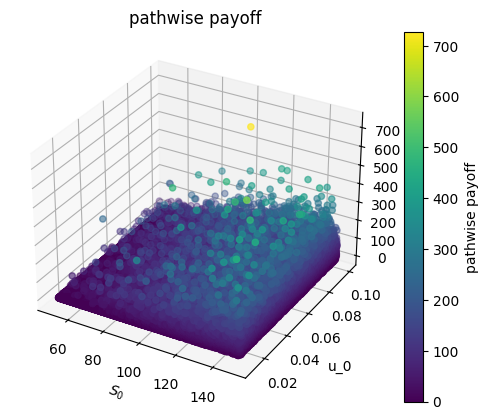

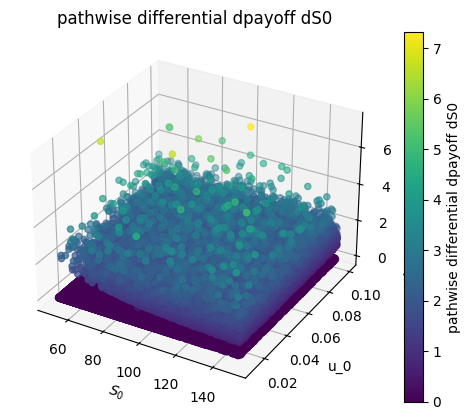

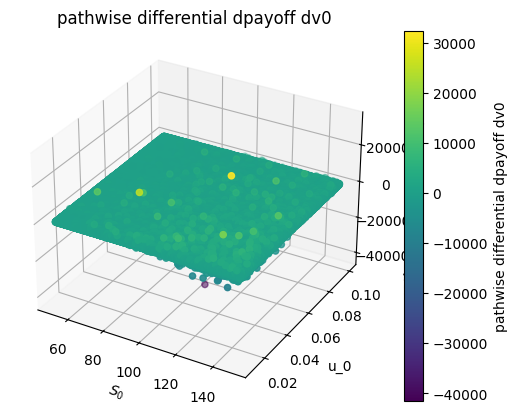

In [ ]:
# old for reference

ds = data_set_precomputed(params=hs_params, key=key, spot_range=spot_range, vol_range=vol_range, is_test=False)

xs = ds.initial_states[..., 0]
ys = ds.initial_states[..., 1]

fig_payoff = plot_3d_differential_data(xs, ys, ds.payoffs, "pathwise payoff")
fig_dS = plot_3d_differential_data(xs, ys, ds.differentials.S0, "pathwise differential dpayoff dS0")
fig_dv = plot_3d_differential_data(xs, ys, ds.differentials.v0, "pathwise differential dpayoff dv0")

In [ ]:
## for testing, timing
#
#import time
#import jax
#import jax.numpy as jnp
#
#key, key_state = jrandom.split(key)
#batch_size = 256
#minvals=jnp.array([ref_model.spot_range.minval, ref_model.vol_range.minval])
#maxvals=jnp.array([ref_model.spot_range.maxval, ref_model.vol_range.maxval])
#
#
## 1) Build the two pieces as standalone jitted functions:
#
## 1a) the forward + first‐derivative pass
#def batch_value_and_grad(path_seeds, spots, vols):
#    # vmap over your new_differential_path
#    return jax.vmap(lambda seed, s0, v0: 
#                    ref_model.new_differential_path(seed, 
#                                               n_time_steps=ref_model.mc_time_steps, 
#                                               S0=s0, 
#                                               v0=v0)
#                   )(path_seeds, spots, vols)
#
## 1b) the Hessian‐via‐HVP pass
#def batch_hessian(path_seeds, spots, vols):
#    return jax.vmap(ref_model.hessian_2x2_for_one, in_axes=(0,0,0))(
#        spots, vols, path_seeds
#    )
#
## Now JIT both of them
#jit_valgrad = jax.jit(batch_value_and_grad)
#jit_hess    = jax.jit(batch_hessian)
#
## 2) Warm up (compile) on a small dummy batch
#B = 16
#dummy_seeds = jax.random.split(key, B)
#dummy_states= jnp.zeros((B,2)) 
#_ = jit_valgrad(dummy_seeds, dummy_states[:,0], dummy_states[:,1])
#_ = jit_hess   (dummy_seeds, dummy_states[:,0], dummy_states[:,1])
#
## 3) Now time them on your real batch
#path_seeds = jax.random.split(key, batch_size)
#initial_states = jrandom.uniform(key_state, (batch_size,2), 
#                                  minval=minvals, maxval=maxvals)
#spots = initial_states[:,0]
#vols  = initial_states[:,1]
#
## --- time value+grad ---
#t0 = time.perf_counter()
#y, dydx = jit_valgrad(path_seeds, spots, vols)
## make sure all of it finishes
#y.block_until_ready(); dydx.block_until_ready()
#t1 = time.perf_counter()
#print(f"value+grad pass: {t1-t0:.3f}s for batch of {batch_size}")
#
## --- time Hessian ---
#t0 = time.perf_counter()
#ddydx = jit_hess(path_seeds, spots, vols)
#ddydx.block_until_ready()
#t1 = time.perf_counter()
#print(f"HVP/Hessian pass: {t1-t0:.3f}s for batch of {batch_size}")
#

In [12]:
key = jrandom.PRNGKey(0)

ref_model = Heston(
    spot_range = Range(50.0, 150.0),
    vol_range = Range(0.01, 0.1),
    mc_time_steps=1024,
    K= 100.0,
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0
)

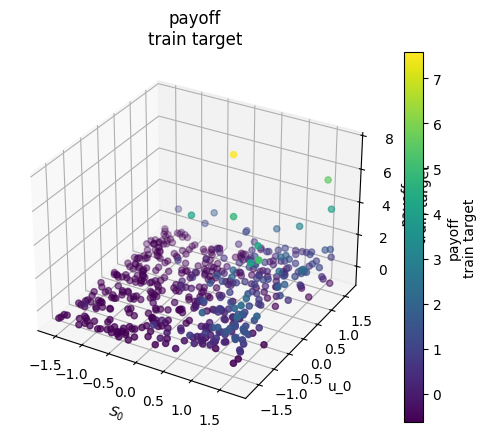

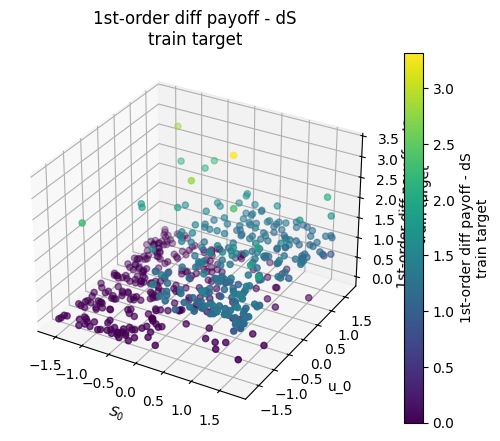

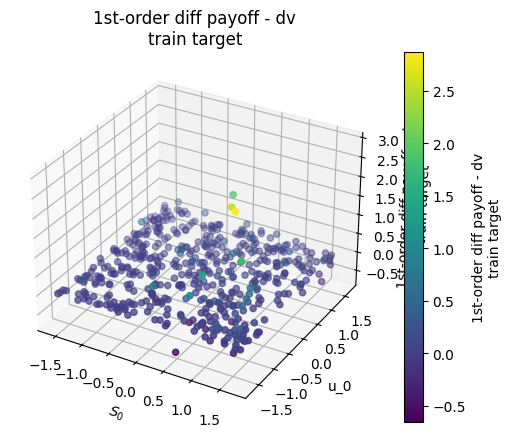

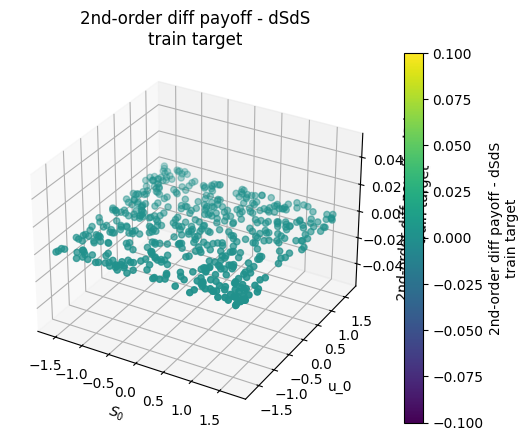

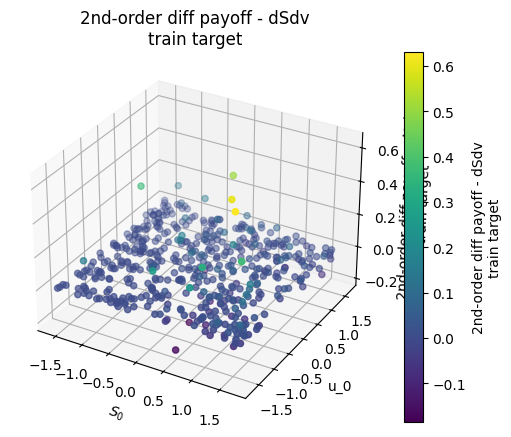

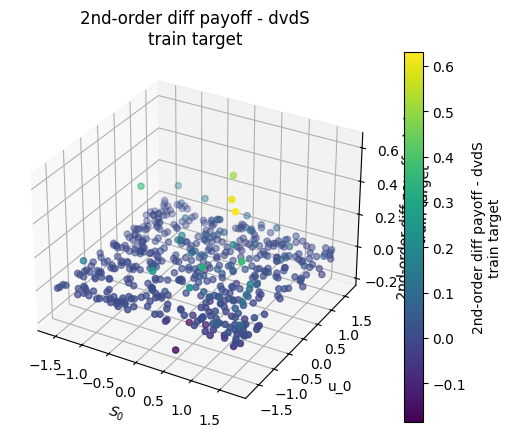

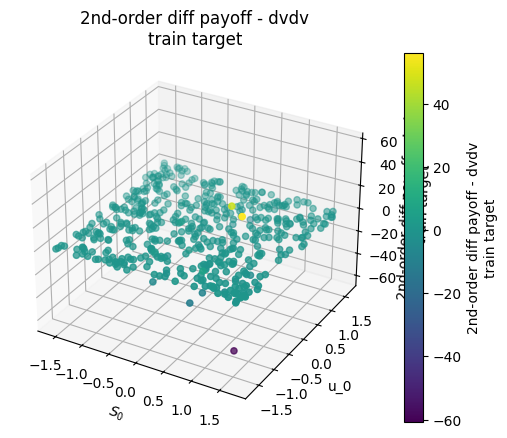

In [ ]:
new_vis_batch = ref_model.sample_data(key, n_samples=512, is_test=False)#8196)

xs = new_vis_batch[0][..., 0]
ys = new_vis_batch[0][..., 1]

ps = new_vis_batch[1]
dps = new_vis_batch[2]
ddps = new_vis_batch[3]

fig_payoff = plot_3d_differential_data(xs, ys, ps, "payoff\ntrain target")

fig_dS = plot_3d_differential_data(xs, ys, dps[:, 0], "1st-order diff payoff - dS\ntrain target")
fig_dv = plot_3d_differential_data(xs, ys, dps[:, 1], "1st-order diff payoff - dv\ntrain target")

fig_dS = plot_3d_differential_data(xs, ys, ddps[:, 0, 0], "2nd-order diff payoff - dSdS\ntrain target")
fig_dv = plot_3d_differential_data(xs, ys, ddps[:, 0, 1], "2nd-order diff payoff - dSdv\ntrain target")
fig_dS = plot_3d_differential_data(xs, ys, ddps[:, 1, 0], "2nd-order diff payoff - dvdS\ntrain target")
fig_dv = plot_3d_differential_data(xs, ys, ddps[:, 1, 1], "2nd-order diff payoff - dvdv\ntrain target")


In [13]:
test_set = ref_model.sample_test_data(key, n_outer=2**9, n_inner=2**6)
print("test_set shapes:", test_set[0].shape, test_set[1].shape, test_set[2].shape, test_set[3].shape)

test_set shapes: (512, 2) (512,) (512, 2) (512, 2, 2)


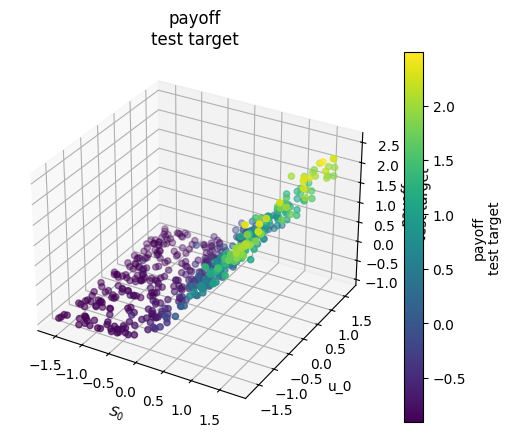

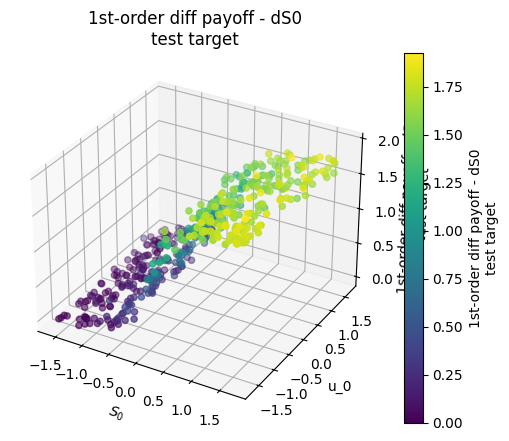

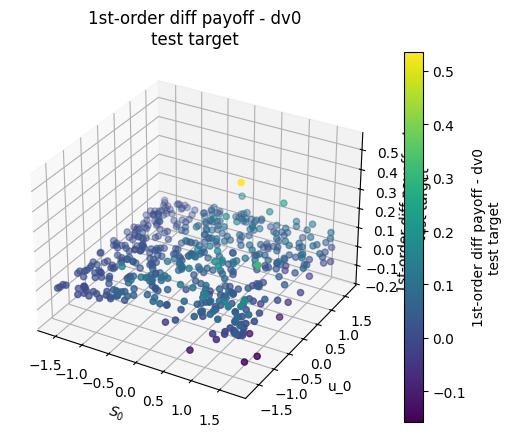

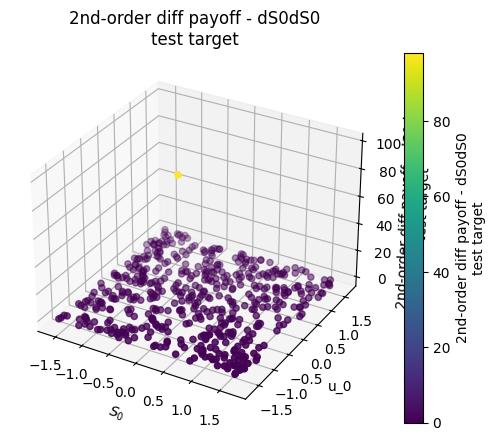

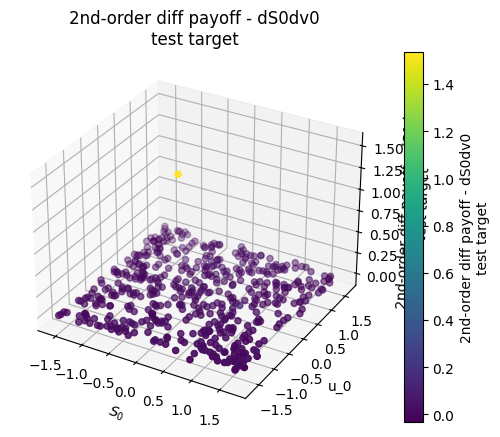

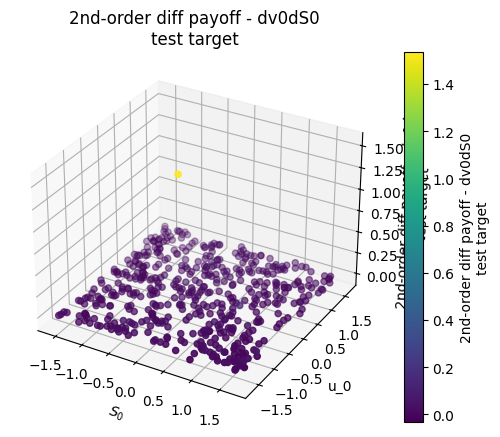

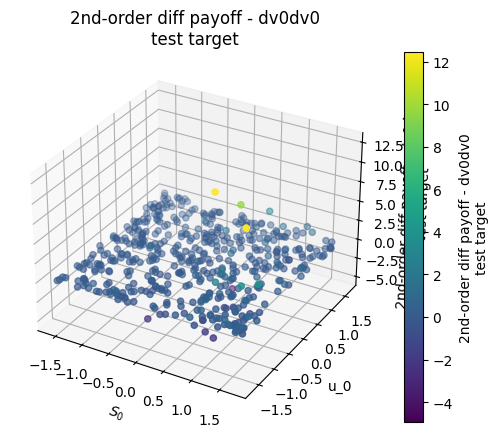

In [15]:

xs = test_set[0][:, 0]
ys = test_set[0][:, 1]
y = test_set[1]
dydx = test_set[2]
ddyddx = test_set[3]

fig_payoff = plot_3d_differential_data(xs, ys, y, "payoff\ntest target")
fig_dS = plot_3d_differential_data(xs, ys, dydx[:, 0], "1st-order diff payoff - dS0\ntest target")
fig_dv = plot_3d_differential_data(xs, ys, dydx[:, 1], "1st-order diff payoff - dv0\ntest target")

fig_dS = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 0], "2nd-order diff payoff - dS0dS0\ntest target")
fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 1], "2nd-order diff payoff - dS0dv0\ntest target")
fig_dS = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 0], "2nd-order diff payoff - dv0dS0\ntest target")
fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 1], "2nd-order diff payoff - dv0dv0\ntest target")

# Learning

### Model

In [14]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

### Loss Functions

In [32]:
def standard_loss_fn(model, batch):
    x = batch[0]
    y = batch[1]
    y_pred = vmap(model)(x)
    return mse(y, y_pred)


@eqx.filter_jit
def second_order_loss_fn(model: eqx.nn.MLP, batch, key: PRNGKeyArray) -> Float:
    
    #batch = ref_model.sample_data(key, batch_size)
        
    x = batch[0]
    y = batch[1]
    dydx = batch[2]
    ddyddx = batch[3]

    #print("x shape: ", x.shape)
    #print("y shape: ", y.shape)
    #print("dydx shape: ", dydx.shape)
    #print("ddyddx shape: ", ddyddx.shape)
    #print("")
    #return .0


    # TODO normalization ?
    #x = (x - x_mean) / x_std
    #y = (y - y_mean) / y_std
    
    # TODO loss balancing
    #lam = 1
    #n_dims = model.in_size
    #lambda_scale = lam * n_dims
    #alpha = 1.0/(1.0 + lambda_scale)
    #beta = lambda_scale/(1.0 + lambda_scale)
    #gamma = 0.0

    alpha = 1/3
    beta = 1/3
    gamma = 1/3
    
    #alpha = 0.2
    #beta = 0.6
    #gamma = 0.2
    
    
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    
    #print("y_pred shape: ", y_pred.shape)
    #print("dydx_pred shape: ", dydx_pred.shape)
    #print("")
    #return .0

    #ddyddx_pred = vmap(jax.hessian(MakeScalar(model)))(x)
    #assert(ddyddx_pred.shape == ddyddx.shape)
    
    #print("ddyddx_pred shape: ", ddyddx_pred.shape)
    #print("")
    #return .0



    value_loss = mse(y_pred, y)
    grad_loss = mse(dydx_pred, dydx) 
    #hess_loss = mse(ddyddx_pred, ddyddx)
    hess_loss = 0


    #jax.debug.print("value loss: {}", value_loss)
    #jax.debug.print("grad loss: {}", grad_loss)
    #jax.debug.print("hess loss: {}", hess_loss)
    #jax.debug.print("---------------------------------")
    
    
    loss = alpha * value_loss + beta * grad_loss + gamma * hess_loss

    return loss




### Train

In [33]:
from itertools import islice

Data: TypeAlias = dict[str, Float[Array, "n_samples ..."]]
DataGenerator: TypeAlias = Generator[Data, None, None]


def train(
    model: PyTree,
    test_data: Tuple,
    optim: optax.GradientTransformation,
    n_epochs: int,
    n_batches_per_epoch: int,
    batch_size: int,
    key: PRNGKeyArray,
) -> PyTree:
    

    @eqx.filter_jit
    def train_step(model: PyTree, opt_state: PyTree, batch_size: int):
        
        batch = ref_model.sample_data(key, batch_size)

        #loss_value, grads = eqx.filter_value_and_grad(standard_loss_fn)(model, batch)
        loss_value, grads = eqx.filter_value_and_grad(second_order_loss_fn)(model, batch, key)
        
        
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    train_loss = jnp.zeros(1)

    n_steps = n_epochs * n_batches_per_epoch
    print(f"Training for {n_epochs} epochs with {n_batches_per_epoch} batches per epoch and batch size {batch_size}.")
    
    keys = jrandom.split(key, n_steps)

    for i, key in enumerate(keys):
        
        
        # print(i)
        # print(batch["normalized_initial_states"])
        # print(batch["normalized_payoffs"].shape)
        with jax.profiler.StepTraceAnnotation("Train Step", step_num=i):  

            model, opt_state, train_loss = train_step(model, opt_state, batch_size)
        
        if i % n_batches_per_epoch == 0:
            epoch_stats = f"Finished epoch {int(i/n_batches_per_epoch)+1} | Train Loss: {train_loss:.5f}"    

            # test data evaluation
            if test_data:
                test_pred_ys, test_pred_dys = vmap(jax.value_and_grad(model))(test_set[0])
                test_pred_ddys = vmap(jax.hessian(MakeScalar(model)))(test_set[0])
                y_error = jnp.sqrt(mse(test_pred_ys, test_set[1]))
                dy_error = jnp.sqrt(mse(test_pred_dys, test_set[2]))
                ddy_error = jnp.sqrt(mse(test_pred_ddys, test_set[3]))
                test_loss = (y_error + dy_error + ddy_error) / 3.0
                epoch_stats += f" | Test Loss: {test_loss:.5f}"
            
            print(epoch_stats)

            
        
        
        
        # def train_inner(model, opt_state, train_loss):
        #     batch = next(train_data)
        #     model, opt_state, train_loss = train_step(model, opt_state, batch)
    
        #     if i % n_steps_per_epoch == 0:
        #         epoch_stats = f"Finished epoch {i:3d} | Train Loss: {train_loss:.5f}"    
        #         print(epoch_stats)
    
        #     return model, opt_state, train_loss
        
        # model = jax.lax.fori_loop(0, n_steps, train_inner, (model, opt_state, train_loss))
    
    return model

In [34]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

# in_size is 2 for initial_spot and initial_vol
n_dims = 2
mlp = eqx.nn.MLP(key=subkey, in_size=n_dims, out_size="scalar", width_size=20, depth=3, activation=jax.nn.elu)

key, subkey = jax.random.split(key)
mlp = init_linear_weight(mlp, trunc_init, key)
surrogate_model = mlp

In [35]:
n_epochs = 30
n_batches_per_epoch = 32
BATCH_SIZE = 256

# NOTE batch:_size * n_batches_per_epoch = 8192

key = jrandom.PRNGKey(0)

ref_model = Heston(
    spot_range = Range(50.0, 150.0),
    vol_range = Range(0.01, 0.1),
    mc_time_steps=1024,
    K= 100.0,
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0
)


#train_dataset = ds
#generator_train_ds = generator_train_data(train_dataset, batch_size=BATCH_SIZE)
#generator_test_ds = None
# total_steps = n_epochs * (len(ds["payoffs"]) // BATCH_SIZE) + n_epochs

# total_steps = 64 * n_epochs
# lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=1e-4) # 3e-4 was default


# for batch in generator_train_ds:
#     x = jnp.stack((batch["initial_spots"], batch["initial_vols"]))
#     y = batch["payoffs"]
#     print(x.shape)
#     print(y.shape)
#     print(type(batch["normalized_initial_states"]))
    # break

#with jax.profiler.trace(f"{current_path}/tmp/jax-trace", create_perfetto_trace=True):
surrogate_model = train(
                        model = surrogate_model, 
                        test_data=test_set,
                        optim=optim, 
                        n_epochs=n_epochs,
                        n_batches_per_epoch=n_batches_per_epoch,
                        batch_size=BATCH_SIZE,
                        key=key
                        )


Training for 30 epochs with 32 batches per epoch and batch size 256.
Finished epoch 1 | Train Loss: 0.60083 | Test Loss: 1.42059
Finished epoch 2 | Train Loss: 0.51420 | Test Loss: 1.36369
Finished epoch 3 | Train Loss: 0.45099 | Test Loss: 1.31371
Finished epoch 4 | Train Loss: 0.40584 | Test Loss: 1.27061
Finished epoch 5 | Train Loss: 0.37414 | Test Loss: 1.23403
Finished epoch 6 | Train Loss: 0.35231 | Test Loss: 1.20376
Finished epoch 7 | Train Loss: 0.33739 | Test Loss: 1.17904
Finished epoch 8 | Train Loss: 0.32679 | Test Loss: 1.15907
Finished epoch 9 | Train Loss: 0.31873 | Test Loss: 1.14273
Finished epoch 10 | Train Loss: 0.31208 | Test Loss: 1.12906
Finished epoch 11 | Train Loss: 0.30619 | Test Loss: 1.11747
Finished epoch 12 | Train Loss: 0.30084 | Test Loss: 1.10694
Finished epoch 13 | Train Loss: 0.29593 | Test Loss: 1.09740
Finished epoch 14 | Train Loss: 0.29140 | Test Loss: 1.08849
Finished epoch 15 | Train Loss: 0.28711 | Test Loss: 1.08017
Finished epoch 16 | Train

In [36]:
# eval price predictions
test_pred_ys, test_pred_dys = vmap(jax.value_and_grad(surrogate_model))(test_set[0])
test_pred_ddys = vmap(jax.hessian(MakeScalar(surrogate_model)))(test_set[0])


In [37]:
y_error = jnp.sqrt(mse(test_pred_ys, test_set[1]))
dy_error = jnp.sqrt(mse(test_pred_dys, test_set[2]))
ddy_error = jnp.sqrt(mse(test_pred_ddys, test_set[3]))

print(f"test y error: {y_error:.4f}")
print(f"test dy error: {dy_error:.4f}")
print(f"test ddy error: {ddy_error:.4f}")

test y error: 0.3633
test dy error: 0.3574
test ddy error: 2.2254


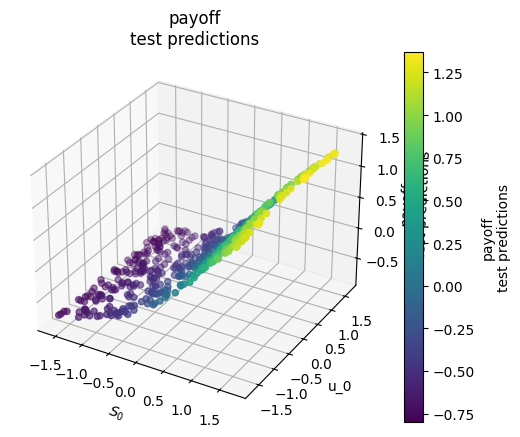

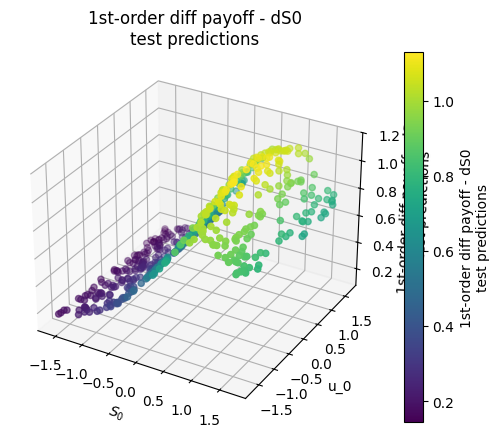

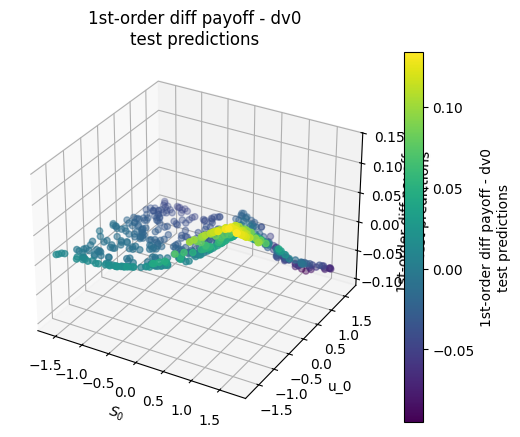

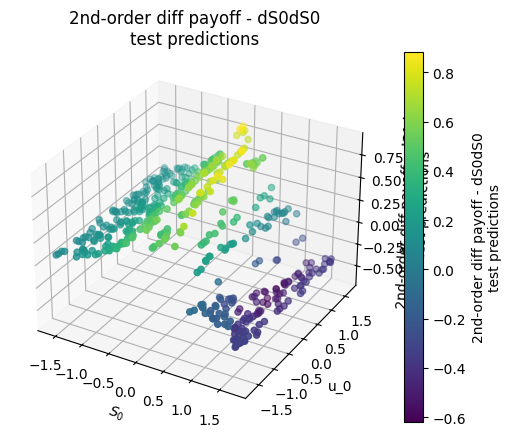

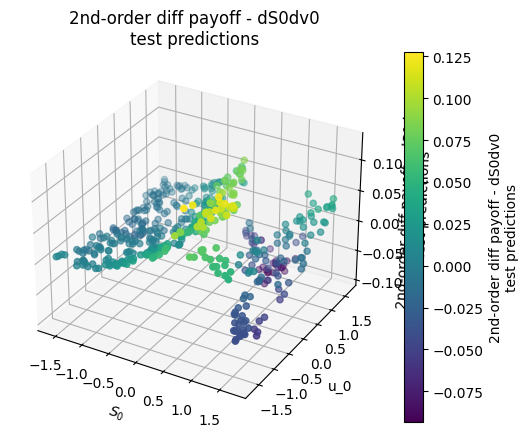

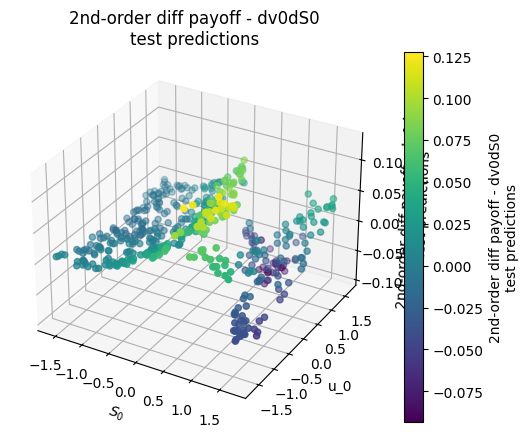

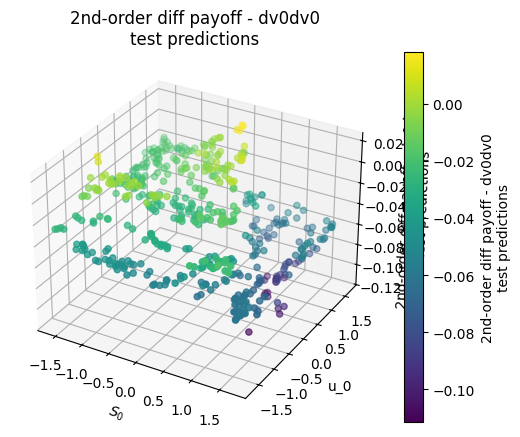

In [38]:
# plot the predictions
xs = test_set[0][:, 0]
ys = test_set[0][:, 1]

fig_payoff = plot_3d_differential_data(xs, ys, test_pred_ys, "payoff\ntest predictions")

fig_dS = plot_3d_differential_data(xs, ys, test_pred_dys[:, 0], "1st-order diff payoff - dS0\ntest predictions")
fig_dv = plot_3d_differential_data(xs, ys, test_pred_dys[:, 1], "1st-order diff payoff - dv0\ntest predictions")

fig_dS = plot_3d_differential_data(xs, ys, test_pred_ddys[:, 0, 0], "2nd-order diff payoff - dS0dS0\ntest predictions")
fig_dv = plot_3d_differential_data(xs, ys, test_pred_ddys[:, 0, 1], "2nd-order diff payoff - dS0dv0\ntest predictions")
fig_dS = plot_3d_differential_data(xs, ys, test_pred_ddys[:, 1, 0], "2nd-order diff payoff - dv0dS0\ntest predictions")
fig_dv = plot_3d_differential_data(xs, ys, test_pred_ddys[:, 1, 1], "2nd-order diff payoff - dv0dv0\ntest predictions")